# 立体匹配中的评价指标-代码示例

## 依赖包

+ numpy

+ matplotlib

+ scikit-image

+ pytorch

+ pytorch-msssim

如果没有安装相关依赖包，运行下面代码安装，也可以手动安装。

如果已经安装，请忽略下面的的代码块

In [ ]:
!pip install -r requirements.txt

下面代码为设置绘制图片嵌入jupyter输出栏显示

In [1]:
%matplotlib inline

## 1、图像相似度评价指标

包括MSE、PSNR、SSIM和MS-SSIM。

### 1.1 生成退化图像

使用skimage包中的camera图片生成带噪声和提高亮度的退化图片。

> camera灰度图像，大小为512*512

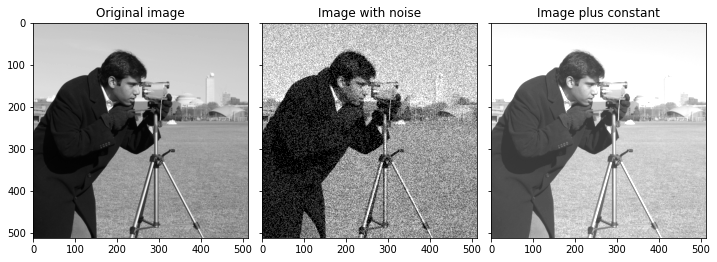

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import img_as_float
from skimage.util import random_noise

img = img_as_float(data.camera())
# img = img_as_float(data.cat())


rows, cols = img.shape

noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
rng = np.random.default_rng()
noise[rng.random(size=noise.shape) > 0.5] *= -1

img_noise = img + noise
img_const = img + abs(noise)

# 显示图像
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()

### 1.2 基于误差敏感度的评价指标

MSE和PSNR，他们使用线性变换来分解图像信号，这不会涉及到相关性。

### 1.2.1 MSE

定义：给定一个大小为$m \times n$的干净图像I和噪声图像K

$$MSE = \frac{1}{mn}\sum^{m-1}_{i=0}\sum^{n-1}_{j=0}[I(i,j)-K(i,j)]^{2}$$

下面使用skimage中提供的接口进行计算`skimage.metrics.mean_squared_error(img1,img2)`

[skimage-mse接口地址](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.mean_squared_error)

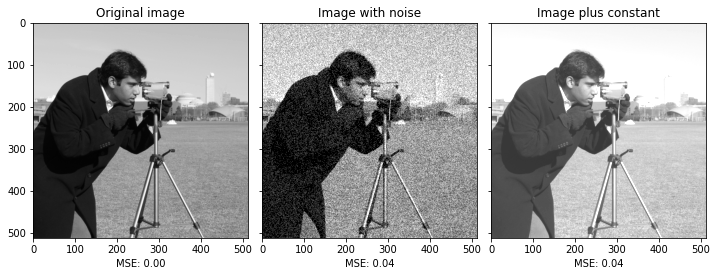

In [3]:
from skimage.metrics import mean_squared_error

# 计算MSE值
mse_none = mean_squared_error(img, img)

mse_noise = mean_squared_error(img, img_noise)

mse_const = mean_squared_error(img, img_const)

axfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(f'MSE: {mse_none:.2f}')
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(f'MSE: {mse_noise:.2f}')
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(f'MSE: {mse_const:.2f}')
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()

#### 1.2.2 PSNR


$$PSNR = 10 * log_{10}(\frac{MAX^{2}_{I}}{MSE})$$

> 像素值取0-255时$MAX_{I}=255$，像素值取0-1时$MAX_{I}=1$
> 
下面使用skimage中提供的接口进行计算`skimage.metrics.peak_signal_noise_ratio(im1, im2, 255)`

[skimage-psnr接口地址](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.peak_signal_noise_ratio)

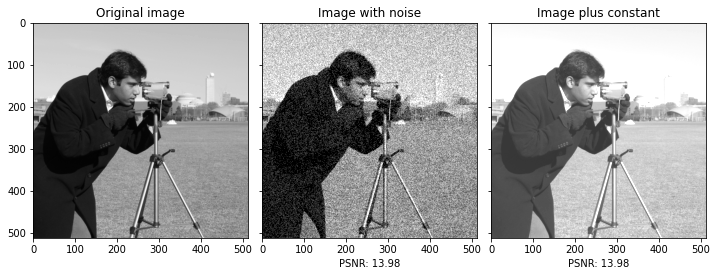

In [4]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# 计算PSNR值
psnr_noise = psnr(img, img_noise)

psnr_const = psnr(img, img_const)

# 画图
axfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(f'PSNR: {psnr_noise:.2f}')
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(f'PSNR: {psnr_const:.2f}')
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()

### 1.3 结构相似性指标

在比较图像相似性时，MSE和PSNR虽然易于实施但并不能很好地表征相似性程度。

SSIM结构相似性旨在通过考虑纹理来解决这一缺点。

#### 1.3.1 SSIM

定义：对比样本$x$和$y$的**亮度（luminance)**、**对比度（contrast）**和**结构(structure)**。

+ 亮度、对比度和结构三个分量对比计算公式：

$$ l(x,y) = \frac{2\mu_{x}\mu_{y}+c_{1}}{\mu^{2}_{x}+\mu^{2}_{y}+c_{1}}$$

$$ c(x,y) = \frac{2\sigma_{x}\sigma_{y}+c_{2}}{\sigma^{2}_{x}+\sigma^{2}_{y}+c_{2}}$$

$$ s(x,y) = \frac{\sigma_{xy}+c_{3}}{\sigma_{x}\sigma_{y}+c_{3}}$$

+ 结构相似性SSIM计算公式：

$$SSIM = [l(x,y)^{\alpha} * c(x,y)^{\beta} * s(x,y)^{\gamma}]$$

> 取$\alpha=\beta=\gamma=1$

$$SSIM=\frac{(2\mu_{x}\mu_{y}+c_{1})(2\sigma_{xy}+c_{2})}{(\mu^{2}_{x}+\mu^{2}_{y}+c_{1})(\sigma^{2}_{x}+\sigma^{2}_{y}+c_{2})}$$

> **SSIM最大值为1**
> 
> $c_{3}$、$\alpha$、$\beta$和$\gamma$是超参数，经验参考值如：$c_{3}=c_{2}/2、\alpha=\beta=\gamma=1$
> 
> $\mu_{x}、\mu_{y}$为$x$和$y$的均值，$\sigma_{xy}$为$x$和$y$的协方差，$\sigma^{2}_{x}、\sigma^{2}_{x}$为$x$和$y$的方差
> 
> 常数$c_{1}=(k_{1}L)^{2},c_{2}=(k_{2}L)^{2}$可以避免分母为0，$k_{1}=0.01,k_{2}=0.03$为默认值，$L=2^{B}-1$为图片像素的取值范围，$B$为图像位数。
>

下面代码调用skimage中的接口`skimage.metrics.structural_similarity(im1, im2, data_range)`计算SSIM

[skimage-ssim接口地址](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity)

**可以看出SSIM指标更能体反映出图像的相似性。**



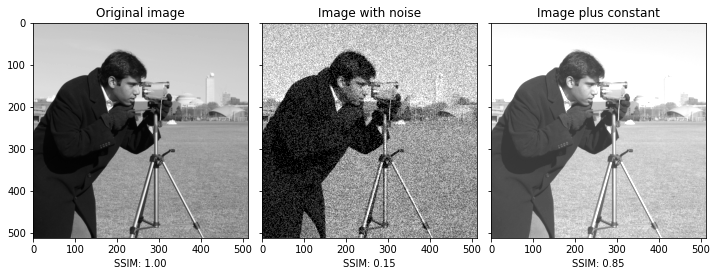

In [5]:
from skimage.metrics import structural_similarity as ssim

# 计算SSIM
ssim_none = ssim(img, img, data_range=img.max() - img.min())

ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min())

ssim_const = ssim(img, img_const,
                  data_range=img_const.max() - img_const.min())

# 画图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(f'SSIM: {ssim_none:.2f}')
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(f'SSIM: {ssim_noise:.2f}')
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(f'SSIM: {ssim_const:.2f}')
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()

#### 1.3.2 MS-SSIM

多尺度结构相似性，图片按照一定规则，由大到小缩放。

计算公式：

$$ MS-SSIM(x,y) = [l_{M}(x,y)]^{\alpha_{M}} * \prod \limits_{j = 1}^{M}([c_{j}(x,y)]^{\beta_{j}} * [s_{j}(x,y)]^{\gamma_{j}})$$

> M一般取5，也就是缩小4次即4个尺度
> $\alpha_{M},\beta_{j},\gamma_{j}$为相关重要性权重：
>
> + $\alpha_{M}$表示最后一个尺度的亮度相关重要性权重
>
> + $\beta{j}$表示第j个尺度的对比度相关重要性权重
>
> + $\gamma{j}$表示第j个尺度的结构相关重要性权重
>
> 论文中这些参数标定为：$\beta_{1}=\gamma_{1}=0.0448,\beta_{2}=\gamma_{2}=0.2856,\beta_{3}=\gamma_{3}=0.3001,\beta_{4}=\gamma_{4}=0.2363,\alpha_{5}=\beta_{5}=\gamma_{5}=0.1333$

下面使用PyTorch提供的接口计算MS-SSIM。

[pytorch-msssim源码Github地址](https://github.com/VainF/pytorch-msssim)

[pytorch-msssim包地址](https://pypi.org/project/pytorch-msssim/)

> 接下来的示例使用彩色图像进行

##### 1.3.2.1 定义图像处理方法

包括：

+ 灰度图像转彩色图像 `rgbImg`

+ 噪声图像 `noisedImg`

+ 图像到张量 `img2tensor`

In [6]:
import torch

from skimage import data
from skimage import color
from skimage import img_as_float
from skimage.util import random_noise

def rgbImg(img):
    '''output shape HWC'''
    _img = img_as_float(img)
    if len(_img.shape) == 2:
        _img = color.gray2rgb(_img)
    return _img

def noisedImg(img,sigma = 0.2):
    _img = random_noise(img, var=sigma**2)
    return _img

def img2tensor(img):
    '''output shape-NCHW type-Tensor'''
    tensor = torch.tensor(img)
    _tensor = tensor.permute(2, 0, 1)
    _img = _tensor.unsqueeze(0)
    return _img

##### 1.3.2.2 生成彩色图像

使用scikit-image中的camera图像，将其转化为RGB图像并添加噪声

> RGB版本的camera图像形状为(512,512,3)
>
> 顺便计算skimage中ssim的值，用于后面验证pytorch中ssim的正确性

skimage-ssim sigma=0.1:  0.28516364609101846
skimage-ssim sigma=0.3:  0.08089756872432304


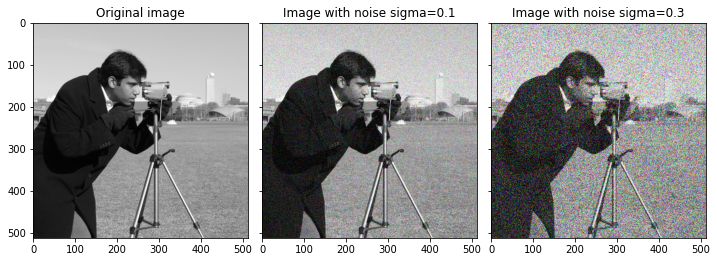

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import img_as_float
from skimage.util import random_noise
from skimage.metrics import structural_similarity as ssim

img = rgbImg(img_as_float(data.camera()))

img_noise_1 = noisedImg(img, sigma=0.1) 
img_noise_2 = noisedImg(img, sigma=0.3)

# channel_axis=2的作用与multichannel=True相同
print("skimage-ssim sigma=0.1: ", 
      ssim(img, img_noise_1,win_size=11, channel_axis=2,
        sigma=1.5, data_range=1.0, use_sample_covariance=False,
        gaussian_weights=True))

print("skimage-ssim sigma=0.3: ", 
      ssim(img, img_noise_2,win_size=11, channel_axis=2,
        sigma=1.5, data_range=1.0, use_sample_covariance=False,
        gaussian_weights=True))

# 显示图像
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, vmin=0, vmax=1)
ax[0].set_title('Original image')

ax[1].imshow(img_noise_1, vmin=0, vmax=1)
ax[1].set_title('Image with noise sigma=0.1')

ax[2].imshow(img_noise_2, vmin=0, vmax=1)
ax[2].set_title('Image with noise sigma=0.3')

plt.tight_layout()
plt.show()

##### 1.3.2.3 MS-SSIM的PyTorch实现

使用`pytorch-msssim`提供的接口计算MS-SSIM

输入的形状为 (N,3,H,W) 一个批量的非负RGB图像，像素值范围是0~255

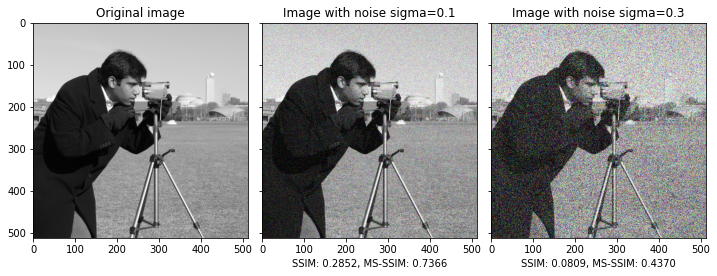

In [8]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

image = img2tensor(img)
image_noise_1 = img2tensor(img_noise_1)
image_noise_2 = img2tensor(img_noise_2)

ssim1 = ssim(image, image_noise_1, data_range=1.0, size_average=False).item() 
ssim2 = ssim(image, image_noise_2, data_range=1.0, size_average=False).item() 
msssim1 = ms_ssim(image, image_noise_1, data_range=1.0, size_average=False).item() 
msssim2 = ms_ssim(image, image_noise_2, data_range=1.0, size_average=False).item() 

# 画图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, vmin=0, vmax=1)
ax[0].set_title('Original image')

ax[1].imshow(img_noise_1, vmin=0, vmax=1)
ax[1].set_xlabel(f'SSIM: {ssim1:.4f}, MS-SSIM: {msssim1:.4f}')
ax[1].set_title('Image with noise sigma=0.1')

ax[2].imshow(img_noise_2, vmin=0, vmax=1)
ax[2].set_xlabel(f'SSIM: {ssim2:.4f}, MS-SSIM: {msssim2:.4f}')
ax[2].set_title('Image with noise sigma=0.3')

plt.tight_layout()
plt.show()

> 可以观察到pytorch版本的ssim和skimage中的ssim结果一致